# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline


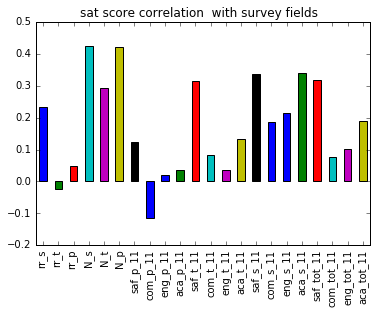

In [12]:
ax = correlations[survey_fields].plot(kind='bar')
ax.set_title("sat score correlation  with survey fields  ")

Information about survey columns name are available in https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8. Below are listed top-5 most correlated with sat scores:  
- N_s	Number of student respondents
- N_t	Number of teacher respondents
- N_p	Number of parent respondents
- saf_s_10	Safety and Respect score based on student responses
- aca_s_10	Academic expectations score based on student responses

Least correlated columns survey:
- eng_p_10	Engagement score based on parent responses
- eng_t_10	Engagement score based on teacher responses
- rr_t	Teacher Response Rate
- aca_p_10	Academic expectations score based on parent responses


It is interesting that the most correlated are the columns with the number of responders. Probably that mean that if more people are respond survey they are generally more engaged in the test. It also worth note that studends which expected more has better sat score. Something what was expected that safety and respect based on student responses impact sat results. 

The interesting thing is that engagement score based on parent and teacher are basicaly not correlated with the score. That mean that something what other see is not exactly real student's engagement. Also parent's expectations are not very good measure what will be the final result.

Let investigate more about safety and respect.

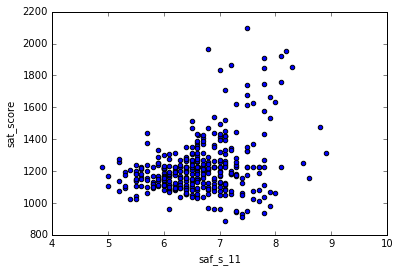

In [13]:
combined.plot.scatter("saf_s_11","sat_score")

We see that top sat scores have been achieved in the schools where safety score are higher.  There is also visible that many shcools in which studends feel safe (score 7-8) achieved one of the lowest sat score. Also the most safest schools did not achieved the best score results. 

In [14]:
import numpy as np
mean_districts = combined.groupby("school_dist").agg(np.mean)
lat_list = mean_districts["lat"].tolist()
lon_list = mean_districts["lon"].tolist()
safety_districts = mean_districts["saf_s_11"]
# mean_districts[["saf_s_11","lat","lon"]]

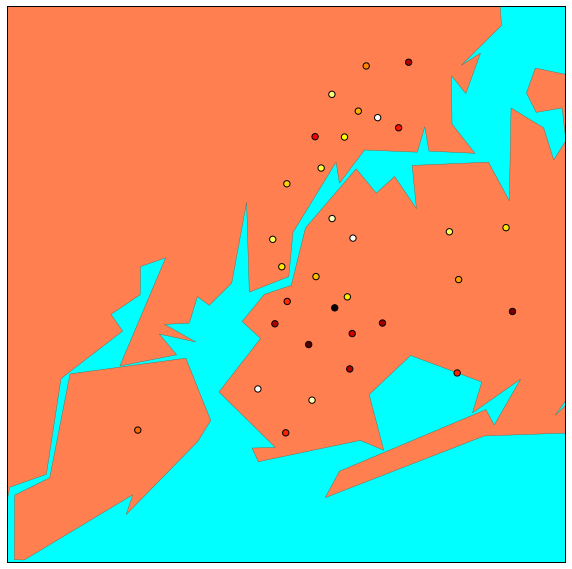

In [15]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawmapboundary(fill_color='aqua')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='coral',lake_color='aqua')


m.scatter(lon_list,lat_list,s=40,zorder=2,latlon=True,c=safety_districts,cmap="hot")

The map shows aggregated safety by districts. Red color means less safe districts, whiter is more safe. We see that there is a lot dark spots in Brooklyn. The safest borough is Manhatan there is no any dark spots on the map. In the Bronx there is both some dangerous districts as the very safe. Similiar is with Queens.

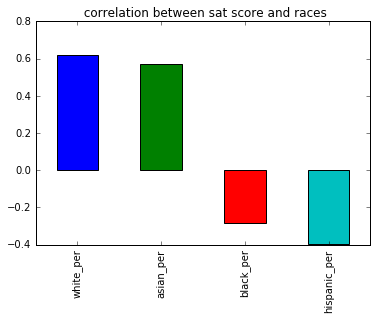

In [16]:
race_cols = ["white_per","asian_per","black_per","hispanic_per"]
ax = correlations[race_cols].plot(kind='bar')
ax.set_title(" correlation between sat score and races")

There is strong correlation between race and sat score. It seems that school with more white and asian race people received much better sat scores than hispanic and black race. In those cases the correlation is negative - more hispanic and black students impact lower sat scores. Let see how the scatter plots looks like.

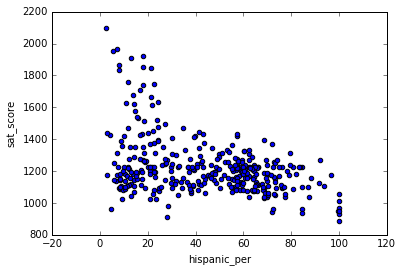

In [17]:
combined.plot.scatter("hispanic_per","sat_score")

The correlation is between hispanic_per and sat score is strong. It is visible that the highest scores are in the schools with the lower hispanic students percent. The schools with nearly all the hispanic's students received the poorest results. 

In [18]:
combined.loc[combined["hispanic_per"]>95,"school_name"]


44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

All listed school (with hispanic rate>95%) are for immigrants. After some research there is no particular borough where those schools are located. Lot of those schools are dual languages. Let investigate something oposite - school with smalll hispanic's students rate and high sat scores.

In [19]:
combined.loc[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800),"school_name"]

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

Most of the listed schools (with high score and low not a low hispanic student rate) are focused on technical and science. There are different borough where schools are located.

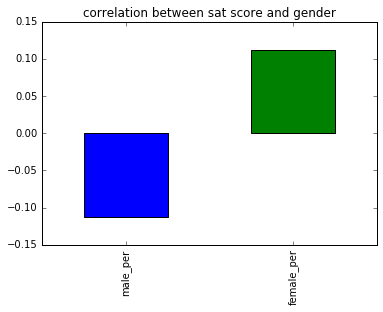

In [20]:
gender_ax = correlations[["male_per","female_per"]].plot(kind='bar')
gender_ax.set_title("correlation between sat score and gender")

It is interesting that male are negative correlation beetween percent male in schools and sat score. Women make SAT test better that men.

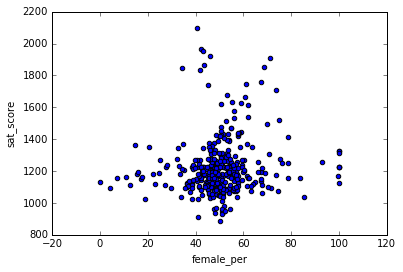

In [21]:
combined.plot.scatter("female_per","sat_score")

It is hard to see any strong pattern in the scatter plot. The highest scores in schools are visible in the schools where there is a slight discrepancy in number of man and women. There is two SAT score peaks - one where in schools are 40% of women, and second with the women percentage about 60%. It is also noticable that there are much more schools with number of girls and boys are divided approximately half by half. 

The schools where there are only girls scored slightly better than schools where there are only boys.

In [22]:
combined.loc[(combined["female_per"]>60) & (combined["sat_score"]>1700),"school_name"]



5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

After googling all above schools appears to be public.  

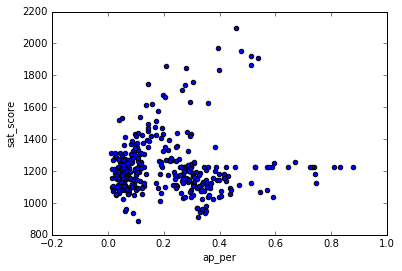

In [23]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter("ap_per","sat_score")

In some schools there are positivie correlation between people who have taken both of the exams. In many cases the growth of students who taken ap test in schools doesn't mean better SAT results. 

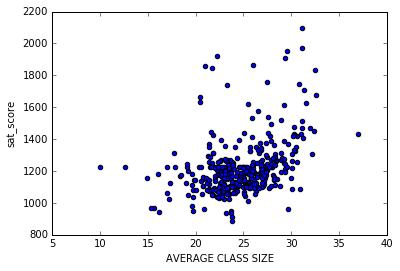

In [24]:
combined.plot.scatter('AVERAGE CLASS SIZE',"sat_score")

The SAT score is increasing with the Average class size. There is a  It could be related to copetitive or cooperation between students. 